In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/autos.csv', encoding = 'ISO-8859-1')

In [3]:
#Retirada de features que provavelmente nao afetam o preco:
data.drop(['dateCrawled','monthOfRegistration','dateCreated','nrOfPictures','lastSeen'],
          axis = 1, inplace = True)

#Como ha muitos nomes diferentes aparecendo soh uma vez, tambem eh prudente deletar:
data.drop('name', axis = 1, inplace = True)

#Retirada de dados desbalanceados:
data.drop(['seller','offerType'], axis = 1, inplace = True)
data_original = data
# %% Retirada de valores inconsistentes
# De acordo com o artigo do medium: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba


In [4]:
from scipy import stats
pd.set_option('display.max_columns', None)

#Lista de features numericas para analisar outliers:
numft = ['price','yearOfRegistration','powerPS','kilometer','postalCode']

#Se puramente igualasse ele consideraria o mesmo objeto (foi o que deu aqui, sei lah)
data_zscore = data.copy()

In [5]:
# %% Criando dataframe que permite a retirada de outliers
for feat in numft:
    data_zscore[feat] = np.abs(stats.zscore(data_zscore[feat]))

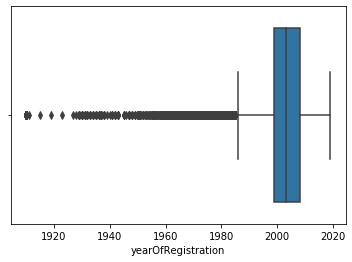

In [6]:
#Definindo threshold de 3 (3 desvios padroes):
threshold = 3
#Isso aqui vai me retornar as colunas e linhas com outliers:
iout = np.where(data_zscore[numft] > 3)

#Se eu quiser visualizar nos dados originais algum outlier a partir disso:
#Para ver o original precisaria fazer o standardscaler reverso
data.iloc[iout[0][500],iout[1][500]]

#No iout ele pode retornar duplicidade de linhas caso em uma mesma linha ocorra mais de um outlier
#Portanto este pequeno codigo se utiliza do bultin set para retornar as linhas unicas
irowsunique = list(set(list(iout[0])))

#Limpeza a partir dos indeces de linhas e colunas retornados
data_nooutlier = data.drop(data.index[irowsunique])

#Visualizacao em boxplot para verificar se realmente deletou outliers
sns.boxplot(data_nooutlier['yearOfRegistration'])


## Valores Faltantes

- Para visualizar se há valores faltantes em cada feature

In [7]:
np.sum(data_nooutlier.isnull())/data_nooutlier.shape[0]


price                 0.000000
abtest                0.000000
vehicleType           0.096871
yearOfRegistration    0.000000
gearbox               0.049342
powerPS               0.000000
model                 0.051710
kilometer             0.000000
fuelType              0.084682
brand                 0.000000
notRepairedDamage     0.187863
postalCode            0.000000
dtype: float64

- Para retornar apenas as linhas que não possuem valores faltantes

In [8]:
data_nomissing = data_nooutlier[data_nooutlier.isnull().any(axis = 1)==False]

- Não há mais valores faltantes

In [9]:
data_nomissing.isnull().sum().sum()

0

- Quantas linhas retiramos em relação ao anterior

In [10]:
data_nomissing.shape[0]/data_nooutlier.shape[0]

0.7098615693568017

- Em relação a base de dados original:

In [11]:
data_nomissing.shape[0]/data.shape[0]

0.6954953597037101

# Label Encoder

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
def ft_str2num(data):
    #Retornar, em formato de número, quais serao as features do tipo object que serao transformadas 
    obj_features = list(data.select_dtypes(include = 'object'))
    obj_ft = [data.columns.get_loc(x) for x in obj_features]
    return obj_ft

def label_encoder(data):
    """Funcao que permite transformar todas as features do tipo object"""
    
    label_encoder = LabelEncoder()
    
    obj_ft = ft_str2num(data)
    
    #Pode ser necessario transformar para string, mas na maioria dos casos nao (afinal já é objeto)
#     def obj2str(df, features):
#     for a in features:
#         df[a] = df[a].astype(str)
#     return df

#     data = obj2str(data, object_features_train)
    
    #Funcao que realizara efetivamente a transformacao
    def le(df, obj_ft):
        le = LabelEncoder()
        for ft in obj_ft:
            df[:,ft] = le.fit_transform(df[:,ft])
        return df

    data_le = pd.DataFrame(le(data.values, obj_ft), columns = data.columns).astype(float)
    
    return data_le

In [14]:
data_le = label_encoder(data_nomissing)

In [15]:
data_le

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,postalCode
0,1500.0,1.0,4.0,2001.0,1.0,75.0,118.0,150000.0,1.0,37.0,1.0,91074.0
1,3600.0,1.0,4.0,2008.0,1.0,69.0,103.0,90000.0,3.0,31.0,1.0,60437.0
2,650.0,1.0,6.0,1995.0,1.0,102.0,11.0,150000.0,1.0,2.0,0.0,33775.0
3,2200.0,1.0,2.0,2004.0,1.0,109.0,8.0,150000.0,1.0,25.0,1.0,67112.0
4,0.0,1.0,6.0,1980.0,1.0,50.0,40.0,40000.0,1.0,37.0,1.0,19348.0
...,...,...,...,...,...,...,...,...,...,...,...,...
258391,3200.0,0.0,6.0,2004.0,1.0,225.0,142.0,150000.0,1.0,30.0,0.0,96465.0
258392,1150.0,0.0,1.0,2000.0,1.0,0.0,249.0,150000.0,1.0,24.0,1.0,26624.0
258393,1199.0,1.0,2.0,2000.0,0.0,101.0,108.0,125000.0,1.0,32.0,1.0,26135.0
258394,9200.0,1.0,1.0,1996.0,1.0,102.0,224.0,150000.0,3.0,37.0,1.0,87439.0


# One Hot Encoder

In [68]:
from sklearn.preprocessing import OneHotEncoder

In [80]:
X_df = data_le.drop('price', axis = 1)

In [81]:
X_df

,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,postalCode
0,1.0,4.0,2001.0,1.0,75.0,118.0,150000.0,1.0,37.0,1.0,91074.0
1,1.0,4.0,2008.0,1.0,69.0,103.0,90000.0,3.0,31.0,1.0,60437.0
2,1.0,6.0,1995.0,1.0,102.0,11.0,150000.0,1.0,2.0,0.0,33775.0
3,1.0,2.0,2004.0,1.0,109.0,8.0,150000.0,1.0,25.0,1.0,67112.0
4,1.0,6.0,1980.0,1.0,50.0,40.0,40000.0,1.0,37.0,1.0,19348.0
...,...,...,...,...,...,...,...,...,...,...,...
258391,0.0,6.0,2004.0,1.0,225.0,142.0,150000.0,1.0,30.0,0.0,96465.0
258392,0.0,1.0,2000.0,1.0,0.0,249.0,150000.0,1.0,24.0,1.0,26624.0
258393,1.0,2.0,2000.0,0.0,101.0,108.0,125000.0,1.0,32.0,1.0,26135.0
258394,1.0,1.0,1996.0,1.0,102.0,224.0,150000.0,3.0,37.0,1.0,87439.0


In [84]:
obj_ft = ft_str2num(data.drop('price', axis = 1))

In [85]:
obj_ft

[0, 1, 3, 5, 7, 8, 9]

In [86]:
len(obj_ft)

7

In [87]:
onehot = OneHotEncoder(sparse=False, categories=obj_ft)

In [88]:
X = X_df.values

In [89]:
from sklearn.compose import ColumnTransformer

In [90]:
ct = ColumnTransformer([('one_hot_encoder',OneHotEncoder(categories= 'auto'), obj_ft)], remainder='passthrough')

In [91]:
X = ct.fit_transform(X).toarray()

In [92]:
X = pd.DataFrame(X)

In [93]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2001.0,75.0,150000.0,91074.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2008.0,69.0,90000.0,60437.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### Divisão entre treino e teste

In [101]:
X = X
y = data_le['price']

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train.shape

(180877, 314)

# Implementação Rede Neural

In [117]:
from keras.models import Sequential
from keras.layers import Dense

## Arquitetura da rede neural 

- Rede neural do tipo sequencial 

In [118]:
regressor = Sequential()

- Primeira camada oculta

In [119]:
regressor.add(Dense(units = 150, activation ='relu', input_dim = X_train.shape[1]))

- Segunda camada oculta

In [120]:
regressor.add(Dense(units = 150, activation ='relu'))

- Camada de saída

In [121]:
regressor.add(Dense(units = 1, activation = 'linear'))

- Compilação da rede

In [122]:
regressor.compile(loss = 'mean_absolute_error', 
                 optimizer = 'adam', 
                 metrics = 'mean_absolute_error')

- Resumo da rede neural 

In [123]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 150)               47250     
_________________________________________________________________
dense_11 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 151       
Total params: 70,051
Trainable params: 70,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
regressor.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
5653/5653 [==============================] - 15s 3ms/step - loss: 3801.8811 - mean_absolute_error: 3801.8811
Epoch 2/100
5653/5653 [==============================] - 10s 2ms/step - loss: 3201.3984 - mean_absolute_error: 3201.3984
Epoch 3/100
5653/5653 [==============================] - 17s 3ms/step - loss: 3130.2673 - mean_absolute_error: 3130.2673
Epoch 4/100
5653/5653 [==============================] - 11s 2ms/step - loss: 3075.8274 - mean_absolute_error: 3075.8274
Epoch 5/100
5653/5653 [==============================] - 14s 2ms/step - loss: 3028.2053 - mean_absolute_error: 3028.2053
Epoch 6/100
5653/5653 [==============================] - 9s 2ms/step - loss: 2999.6467 - mean_absolute_error: 2999.6467
Epoch 7/100
5653/5653 [==============================] - 10s 2ms/step - loss: 2968.4102 - mean_absolute_error: 2968.4102
Epoch 8/100
5653/5653 [==============================] - 9s 2ms/step - loss: 2936.4443 - mean_absolute_error: 2936.4443
Epoch 9/100
5653/5653 [===========